## *Table of Contents*

### 1. Introduction

### 2. Explaratory Data Analysis

### 3. Feature Engineering

### 4. Modelling

### 5. Findings & Conclusion

# Sparkify Churn Modelling Project with Pyspark on IBM Cloud / Part 2 - Feature Engineering and Modelling




# 1. Introduction

In this project we will try to predict churn users for music app Sparkify by using Machine Learning. We will use Spark Hadoop platform on IBM Cloud Pak platform since data volume is big.

Firstly, We will discover data and make some feature engineerings. Then we will implement some classification algorithms to predict churn users.

Since churn users are small part of the data ( 22% almost), we will compare algorithms with F1 measure of class 1-churn. F1 metrics is harmonic mean of precision and recall for true class. 

We will make some hyperparameter search to achieve better predictions score after deciding algorithm.

At the end, we will have a solid machine learning model that predicts which users are more likely to churn based on behaviour and usage data we have.

In [5]:
import ibmos2spark, os
# @hidden_cell

if os.environ.get('RUNTIME_ENV_LOCATION_TYPE') == 'external':
    endpoint_3d0f931fa1d6458c88447823501cb446 = 'https://s3.eu-geo.objectstorage.softlayer.net'
else:
    endpoint_3d0f931fa1d6458c88447823501cb446 = 'https://s3.eu-geo.objectstorage.service.networklayer.com'

credentials = {
    'endpoint': endpoint_3d0f931fa1d6458c88447823501cb446,
    'service_id': 'iam-ServiceId-20bc62d1-5323-41ff-ae07-82503750d48d',
    'iam_service_endpoint': 'https://iam.cloud.ibm.com/oidc/token',
    'api_key': 'hGWWFeAoU-xr27mDWYUvqbDUNmkUCjDZwbI0mpRgnemp'
}

configuration_name = 'os_3d0f931fa1d6458c88447823501cb446_configs'
cos = ibmos2spark.CloudObjectStorage(sc, credentials, configuration_name, 'bluemix_cos')

from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
# Since JSON data can be semi-structured and contain additional metadata, it is possible that you might face issues with the DataFrame layout.
# Please read the documentation of 'SparkSession.read()' to learn more about the possibilities to adjust the data loading.
# PySpark documentation: http://spark.apache.org/docs/2.0.2/api/python/pyspark.sql.html#pyspark.sql.DataFrameReader.json

df = spark.read.json(cos.url('medium-sparkify-event-data.json', 'semihh-donotdelete-pr-ichqfi8azvyq08'))
df.take(5)

[Row(artist='Martin Orford', auth='Logged In', firstName='Joseph', gender='M', itemInSession=20, lastName='Morales', length=597.55057, level='free', location='Corpus Christi, TX', method='PUT', page='NextSong', registration=1532063507000, sessionId=292, song='Grand Designs', status=200, ts=1538352011000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', userId='293'),
 Row(artist="John Brown's Body", auth='Logged In', firstName='Sawyer', gender='M', itemInSession=74, lastName='Larson', length=380.21179, level='free', location='Houston-The Woodlands-Sugar Land, TX', method='PUT', page='NextSong', registration=1538069638000, sessionId=97, song='Bulls', status=200, ts=1538352025000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"', userId='98'),
 Row(artist='Afroman', auth='Logged In', firstName='Maverick', gender='M', 

In [6]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import desc
from pyspark.sql.functions import asc
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.functions import *
from pyspark.sql.functions import col

import datetime

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

## Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [7]:
df.count()

543705

In [8]:
df = df.dropna(how='any', subset=['userId', 'sessionId'])
print((df.filter(df["userId"] != "").count() / df.count()))
df = df.filter(df["userId"] != "")

0.9711240470475717


In [9]:
df.count()

528005

# 2. Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

# 3. Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

## a. Pre-Feature Engineerings that we completed on EDA sections:

In [10]:
churn_users = df.filter(df.page == "Cancellation Confirmation").select("userId").dropDuplicates().collect()
churn_user_list =  [str(row.userId) for row in churn_users]
df = df.withColumn("churn", when(col('userId').isin(churn_user_list), 1).otherwise(0))

In [11]:
#udf to convert the ts and registration from timestamp to datetimes
get_timestamp = udf(lambda x : datetime.datetime.fromtimestamp(x/ 1000.0).strftime("%Y-%m-%d %H:%M:%S"))

#apply this udf in the dataframe with your timestamp
df = df.withColumn("datetime", get_timestamp(df.ts))

#apply this udf in the dataframe with your timestamp
df = df.withColumn("register-datetime", get_timestamp(df.registration))

#drop the registration column
df = df.drop("registration")
#drop the ts column
df = df.drop("ts")

#drop other useless columns
df = df.drop("auth")
df = df.select([c for c in df.columns if c not in {'firstName','lastName'}])
df = df.drop("itemInSession")
df = df.drop("method")
df = df.drop("userAgent")
df = df.drop("status")

In [12]:
df_page_pivot = df.groupby(["userId","churn"]).pivot("page").count()
df_page_pivot = df_page_pivot.drop("Cancel")
df_page_pivot = df_page_pivot.drop("Cancellation Confirmation")
df_page_pivot = df_page_pivot.fillna(0)

df_page_count = df.filter("page != 'Cancellation Confirmation' and page != 'Cancel' and page !='Add Friend' and \
   page != 'Submit Downgrade'and page != 'Submit Upgrade'").groupBy('userId').count().alias("count")

df_page_pivot = df_page_pivot.join(df_page_count,['userId'])
df_page_pivot = df_page_pivot.withColumnRenamed("count", "totalPageCount")

for column in df_page_pivot.columns:
    if column not in ['userId', 'totalPageCount',"churn", 'Add Friend','Submit Downgrade','Submit Upgrade']:
        new_column_name = "freq" + column
        df_page_pivot = df_page_pivot.withColumn(new_column_name, df_page_pivot[column] / df_page_pivot['totalPageCount'])
        
df_page_pivot = df_page_pivot.select(['userId', "churn",'Add Friend', 'Submit Downgrade','Submit Upgrade', 'freqAbout',
 'freqAdd to Playlist', 'freqDowngrade','freqError','freqHelp','freqHome','freqLogout','freqNextSong','freqRoll Advert',
 'freqSave Settings','freqSettings','freqThumbs Down', 'freqThumbs Up','freqUpgrade'])

In [13]:
df_count_artist_user = df.filter(df.page == "NextSong").groupby(["userId"]).agg(count("artist"),countDistinct("artist").alias("distinct_artist"))
df_page_pivot = df_page_pivot.join(df_count_artist_user,["userId"])

In [14]:
df_gender_user = df.groupby(["gender","userId"]).agg({"churn":"mean"}).drop("avg(churn)")
df_page_pivot = df_page_pivot.join(df_gender_user,["userId"])

In [15]:
df_length_user = df.filter(df.page=="NextSong").groupby(["userId"]).agg({"length":"sum"})
df_page_pivot = df_page_pivot.join(df_length_user,["userId"])

In [16]:
df_level_user = df.groupby(["userId"]).agg({"level":"last"})
df_page_pivot = df_page_pivot.join(df_level_user,["userId"])

In [17]:
df_location_user = df.groupby(["location","userId"]).agg({"churn":"mean"}).drop("avg(churn)")
df_page_pivot = df_page_pivot.join(df_location_user,["userId"])

In [18]:
df_count_song = df.filter(df.page == "NextSong").groupby(["userId"]).agg(count("song"),countDistinct("song").alias("distinct_song"))
df_page_pivot = df_page_pivot.join(df_count_song,["userId"])

In [19]:
df_session_count = df.groupby(["userId"]).agg(countDistinct("sessionId"))
df_page_pivot = df_page_pivot.join(df_session_count,["userId"])

In [20]:
df_page_pivot.toPandas().head()

,userId,churn,Add Friend,Submit Downgrade,Submit Upgrade,freqAbout,freqAdd to Playlist,freqDowngrade,freqError,freqHelp,...,freqUpgrade,count(artist),distinct_artist,gender,sum(length),last(level),location,count(song),distinct_song,count(sessionId)
0,100010,1,3,0,0,0.000000,0.007576,0.000000,0.0,0.000000,...,0.015152,96,94,F,25870.95074,free,"Bridgeport-Stamford-Norwalk, CT",96,96,2
1,200002,1,2,0,1,0.002564,0.015385,0.007692,0.0,0.002564,...,0.005128,310,287,M,78695.82684,paid,"Chicago-Naperville-Elgin, IL-IN-WI",310,306,5
2,296,1,2,0,1,0.000000,0.020408,0.006803,0.0,0.013605,...,0.006803,112,108,F,28314.15006,paid,"Allentown-Bethlehem-Easton, PA-NJ",112,109,5
3,125,0,3,0,0,0.000000,0.024691,0.000000,0.0,0.024691,...,0.000000,62,61,M,15813.77107,free,"Corpus Christi, TX",62,62,3
4,124,1,26,0,0,0.001410,0.021147,0.009868,0.0,0.004699,...,0.000000,1826,1240,F,456664.04058,paid,"Vineland-Bridgeton, NJ",1826,1611,17


Ready Features we have after EDA:

- Add Friend count
- Submit Downgrade count
- Submit Upgrade count
- Page frequency features: freq about, add to playlist, downgrade, error, help, home, logout,nextsong, roll advert, save settings, settings, thumbs up, thumbs down, upgrade
- Listened Artist Count *count(artist)
- Listened Artist Distinct Count  *count(DISTINCT artist)
- Gender 
- Total Length of Played Songs by seconds *sum(length)
- Subsriciption type paid or free *last(level)
- Location knowledge *location
- How many songs have been played *count(song)
- How many different songs have been played *count(DISTINCT song) 
- How many session user played *count(DISTINCT sessionId)

## b. New Features with Feature Engineering

### Average Session Duration

In [21]:
from pyspark.sql.functions import min, max
df_session_length = df.groupby(["userId","churn","sessionId"]).agg(min("datetime"),max("datetime"))
df_session_length=df_session_length.select('userId','sessionId',
                          to_timestamp('min(datetime)', 'yyyy-MM-dd HH:mm:ss').alias('min_time'),
                          to_timestamp('max(datetime)', 'yyyy-MM-dd HH:mm:ss').alias('max_time'))


In [22]:
df_session_length = df_session_length.withColumn('session_duration',(col("max_time").cast("long") - col("min_time")\
                                                                            .cast("long"))/60)


In [23]:
df_session_length.show(3)

+------+---------+-------------------+-------------------+------------------+
|userId|sessionId|           min_time|           max_time|  session_duration|
+------+---------+-------------------+-------------------+------------------+
|100010|       62|2018-10-08 09:36:32|2018-10-08 13:19:06|222.56666666666666|
|100011|      251|2018-10-23 03:58:24|2018-10-23 18:48:34| 890.1666666666666|
|100025|      269|2018-10-25 03:46:37|2018-10-25 12:11:33|504.93333333333334|
+------+---------+-------------------+-------------------+------------------+
only showing top 3 rows



In [24]:
df_session_length.filter(df_session_length.userId == "200002").show(10)

+------+---------+-------------------+-------------------+------------------+
|userId|sessionId|           min_time|           max_time|  session_duration|
+------+---------+-------------------+-------------------+------------------+
|200002|       91|2018-10-06 17:05:40|2018-10-06 19:57:40|             172.0|
|200002|      239|2018-10-29 21:52:21|2018-10-30 05:23:46| 451.4166666666667|
|200002|      164|2018-10-09 14:28:14|2018-10-09 15:52:08|              83.9|
|200002|        2|2018-10-01 11:30:30|2018-10-01 14:04:25|153.91666666666666|
|200002|      190|2018-10-12 12:10:22|2018-10-12 19:44:26|454.06666666666666|
+------+---------+-------------------+-------------------+------------------+



In [25]:
df_session_avg = df_session_length.groupby("userId").agg({"session_duration":"mean"})
df_session_avg.show(3)

+------+---------------------+
|userId|avg(session_duration)|
+------+---------------------+
|100010|              210.375|
|200002|               263.06|
|   296|    97.03666666666666|
+------+---------------------+
only showing top 3 rows



### Average Song Count Per Session

In [26]:
df_avgsong_allsession = df.groupby(["userId","sessionId"]).agg(count("song"))
df_avgsong_allsession.show(3)

+------+---------+-----------+
|userId|sessionId|count(song)|
+------+---------+-----------+
|   216|     3725|         36|
|    96|     3880|        296|
|    17|     4025|         22|
+------+---------+-----------+
only showing top 3 rows



In [27]:
df_avgsong_per_session = df_avgsong_allsession.groupby("userId").agg({"count(song)":"mean"})
df_avgsong_per_session.show(3)

+------+----------------+
|userId|avg(count(song))|
+------+----------------+
|200002|            62.0|
|   296|            22.4|
|100010|            48.0|
+------+----------------+
only showing top 3 rows



### Average Session Interval Duration by Days

In [28]:
df_session_interval = df.groupby(["userId"]).agg(min("datetime"),max("datetime"),countDistinct("sessionId"))
df_session_interval.show(3)

+------+-------------------+-------------------+----------------+
|userId|      min(datetime)|      max(datetime)|count(sessionId)|
+------+-------------------+-------------------+----------------+
|100010|2018-10-08 09:36:32|2018-10-11 10:38:38|               2|
|200002|2018-10-01 11:30:30|2018-10-30 05:23:46|               5|
|   296|2018-10-02 10:55:51|2018-10-10 16:00:34|               5|
+------+-------------------+-------------------+----------------+
only showing top 3 rows



In [29]:
df_session_interval=df_session_interval.select('userId',
                          to_timestamp('min(datetime)', 'yyyy-MM-dd HH:mm:ss').alias('min_time'),
                          to_timestamp('max(datetime)', 'yyyy-MM-dd HH:mm:ss').alias('max_time'), "count(sessionId)")
df_session_interval.show(3)

+------+-------------------+-------------------+----------------+
|userId|           min_time|           max_time|count(sessionId)|
+------+-------------------+-------------------+----------------+
|100010|2018-10-08 09:36:32|2018-10-11 10:38:38|               2|
|200002|2018-10-01 11:30:30|2018-10-30 05:23:46|               5|
|   296|2018-10-02 10:55:51|2018-10-10 16:00:34|               5|
+------+-------------------+-------------------+----------------+
only showing top 3 rows



In [30]:
df_session_interval = df_session_interval.withColumn('between_time_all_sessions',(col("max_time").cast("long") - col("min_time")\
                                                                            .cast("long"))/86400)
df_session_interval.show(3)

+------+-------------------+-------------------+----------------+-------------------------+
|userId|           min_time|           max_time|count(sessionId)|between_time_all_sessions|
+------+-------------------+-------------------+----------------+-------------------------+
|100010|2018-10-08 09:36:32|2018-10-11 10:38:38|               2|                 3.043125|
|200002|2018-10-01 11:30:30|2018-10-30 05:23:46|               5|       28.745324074074073|
|   296|2018-10-02 10:55:51|2018-10-10 16:00:34|               5|        8.211608796296296|
+------+-------------------+-------------------+----------------+-------------------------+
only showing top 3 rows



In [31]:
df_session_interval = df_session_interval.withColumn("average_interval", 
            df_session_interval["between_time_all_sessions"] / df_session_interval["count(sessionId)"])
df_session_interval.show(3)

+------+-------------------+-------------------+----------------+-------------------------+------------------+
|userId|           min_time|           max_time|count(sessionId)|between_time_all_sessions|  average_interval|
+------+-------------------+-------------------+----------------+-------------------------+------------------+
|100010|2018-10-08 09:36:32|2018-10-11 10:38:38|               2|                 3.043125|         1.5215625|
|200002|2018-10-01 11:30:30|2018-10-30 05:23:46|               5|       28.745324074074073|5.7490648148148145|
|   296|2018-10-02 10:55:51|2018-10-10 16:00:34|               5|        8.211608796296296|1.6423217592592594|
+------+-------------------+-------------------+----------------+-------------------------+------------------+
only showing top 3 rows



In [32]:
df_session_interval = df_session_interval.select(["userId","average_interval"])
df_session_interval.show(3)

+------+------------------+
|userId|  average_interval|
+------+------------------+
|100010|         1.5215625|
|200002|5.7490648148148145|
|   296|1.6423217592592594|
+------+------------------+
only showing top 3 rows



### Tenure feature calculated from registration date 

In [33]:
df_user_tenure = df.groupby("userId","register-datetime").agg(max("datetime"))
df_user_tenure.show(3)

+------+-------------------+-------------------+
|userId|  register-datetime|      max(datetime)|
+------+-------------------+-------------------+
|100026|2018-03-26 14:53:32|2018-11-13 11:23:55|
|   157|2018-08-14 23:04:26|2018-11-27 04:29:18|
|200034|2018-06-15 01:09:29|2018-11-03 22:18:35|
+------+-------------------+-------------------+
only showing top 3 rows



In [34]:
df_user_tenure = df_user_tenure.select('userId',
                          to_timestamp('register-datetime', 'yyyy-MM-dd HH:mm:ss').alias('register-datetime'),
                          to_timestamp('max(datetime)', 'yyyy-MM-dd HH:mm:ss').alias('max(datetime)'))

df_user_tenure = df_user_tenure.withColumn('tenure',(col("max(datetime)").cast("long") - col("register-datetime")\
                                                                            .cast("long"))/86400)
df_user_tenure = df_user_tenure.select(["userId","tenure"])
df_user_tenure.show(3)

+------+------------------+
|userId|            tenure|
+------+------------------+
|100026|231.85443287037037|
|   157|104.22560185185185|
|200034|141.88131944444444|
+------+------------------+
only showing top 3 rows



### Artist Range KPI - Whether user listen same artists or different artists on platform 

In [35]:
df_page_pivot = df_page_pivot.withColumn("artist_range",  
                                    df_page_pivot["distinct_artist"] / df_page_pivot["count(artist)"] )
df_page_pivot.toPandas().head(3)

,userId,churn,Add Friend,Submit Downgrade,Submit Upgrade,freqAbout,freqAdd to Playlist,freqDowngrade,freqError,freqHelp,...,count(artist),distinct_artist,gender,sum(length),last(level),location,count(song),distinct_song,count(sessionId),artist_range
0,100010,1,3,0,0,0.000000,0.007576,0.000000,0.0,0.000000,...,96,94,F,25870.95074,free,"Bridgeport-Stamford-Norwalk, CT",96,96,2,0.979167
1,200002,1,2,0,1,0.002564,0.015385,0.007692,0.0,0.002564,...,310,287,M,78695.82684,paid,"Chicago-Naperville-Elgin, IL-IN-WI",310,306,5,0.925806
2,296,1,2,0,1,0.000000,0.020408,0.006803,0.0,0.013605,...,112,108,F,28314.15006,paid,"Allentown-Bethlehem-Easton, PA-NJ",112,109,5,0.964286


### Last Week Session Trend - Last 7 days vs Previous Week


In [36]:
from pyspark.sql import functions as F
from pyspark.sql import Window

In [37]:
from pyspark.sql.functions import unix_timestamp
from pyspark.sql.types import (DateType, StructType, StructField, StringType)

We need a unix timestamp date for window functions.

In [38]:
df.withColumn("datetime", df['datetime'].cast(DateType()))
df = df.withColumn('datetimeTS', unix_timestamp('datetime'))
df.show(5)

+-----------------+------+---------+-----+--------------------+--------+---------+------------------+------+-----+-------------------+-------------------+----------+
|           artist|gender|   length|level|            location|    page|sessionId|              song|userId|churn|           datetime|  register-datetime|datetimeTS|
+-----------------+------+---------+-----+--------------------+--------+---------+------------------+------+-----+-------------------+-------------------+----------+
|    Martin Orford|     M|597.55057| free|  Corpus Christi, TX|NextSong|      292|     Grand Designs|   293|    1|2018-10-01 00:00:11|2018-07-20 05:11:47|1538352011|
|John Brown's Body|     M|380.21179| free|Houston-The Woodl...|NextSong|       97|             Bulls|    98|    0|2018-10-01 00:00:25|2018-09-27 17:33:58|1538352025|
|          Afroman|     M|202.37016| paid|Orlando-Kissimmee...|NextSong|      178|Because I Got High|   179|    0|2018-10-01 00:01:58|2018-09-03 05:44:15|1538352118|
|   

We create a user , session, time dataframe to analyze sessions distribution.

In [39]:
df_session_limited = df.groupby(["userId","sessionId"]).agg(max("datetimeTS"),max("datetime"))
df_session_limited=df_session_limited.select('userId','sessionId',"max(datetime)", col("max(datetimeTS)").alias("datetimeNew"))

In [40]:
df_session_limited.show(100)

+------+---------+-------------------+-----------+
|userId|sessionId|      max(datetime)|datetimeNew|
+------+---------+-------------------+-----------+
|100002|      293|2018-11-02 08:17:40| 1541146660|
|100025|      287|2018-11-02 17:12:22| 1541178742|
|100028|       28|2018-10-01 06:39:49| 1538375989|
|   148|     2290|2018-10-30 19:39:47| 1540928387|
|   157|     3145|2018-11-06 05:20:17| 1541481617|
|    17|     4025|2018-11-19 12:38:32| 1542631112|
|   177|      176|2018-10-31 11:51:06| 1540986666|
|   190|     1588|2018-10-18 20:33:56| 1539894836|
|   195|     4582|2018-11-28 05:57:55| 1543384675|
|200019|      483|2018-11-06 19:08:01| 1541531281|
|200028|      244|2018-10-23 05:02:36| 1540270956|
|   216|     3725|2018-11-15 19:38:35| 1542310715|
|   250|     4676|2018-11-29 17:17:32| 1543511852|
|   259|     1120|2018-10-11 15:15:35| 1539270935|
|   267|      364|2018-10-19 02:55:30| 1539917730|
|300015|      390|2018-10-27 15:22:57| 1540653777|
|300024|      413|2018-10-23 05

In [41]:
df_session_limited.filter(df_session_limited.userId =="33").show(10)

+------+---------+-------------------+-----------+
|userId|sessionId|      max(datetime)|datetimeNew|
+------+---------+-------------------+-----------+
|    33|     2196|2018-10-24 18:49:09| 1540406949|
|    33|     1905|2018-10-18 17:40:11| 1539884411|
|    33|     4046|2018-11-26 21:56:52| 1543269412|
|    33|     1130|2018-10-17 16:20:03| 1539793203|
|    33|     1869|2018-10-18 03:49:00| 1539834540|
|    33|     1959|2018-10-22 11:10:02| 1540206602|
|    33|     3066|2018-11-06 16:22:21| 1541521341|
|    33|     3301|2018-11-08 05:57:23| 1541656643|
|    33|     3701|2018-11-16 03:58:25| 1542340705|
|    33|      489|2018-10-08 21:18:44| 1539033524|
+------+---------+-------------------+-----------+
only showing top 10 rows



These are the sessions for userId 33 , now we will implement a window function on both last 7 days and 14 days seperately.

In [42]:
days = lambda i: i * 86400
windowSpec7 = Window.partitionBy('userId').orderBy("datetimeNew").rangeBetween(-days(7), 0)
windowSpec14 = Window.partitionBy('userId').orderBy("datetimeNew").rangeBetween(-days(14), 0)

In [43]:
df_session_limited2 = df_session_limited.withColumn('sessions_in_7_days',F.count('datetimeNew').over(windowSpec7))
df_session_limited2 = df_session_limited2.withColumn('sessions_in_14_days',F.count('datetimeNew').over(windowSpec14))
df_session_limited2.sort(df_session_limited2["userId"]).show()

+------+---------+-------------------+-----------+------------------+-------------------+
|userId|sessionId|      max(datetime)|datetimeNew|sessions_in_7_days|sessions_in_14_days|
+------+---------+-------------------+-----------+------------------+-------------------+
|    10|        9|2018-10-09 03:22:44| 1539055364|                 1|                  1|
|   100|     3332|2018-11-07 03:14:12| 1541560452|                 8|                 11|
|   100|     3018|2018-11-05 04:44:48| 1541393088|                 5|                  9|
|   100|     3175|2018-11-06 04:31:32| 1541478692|                 6|                 10|
|   100|     2602|2018-10-31 10:11:52| 1540980712|                 4|                  7|
|   100|     2976|2018-11-02 09:11:39| 1541149899|                 5|                  9|
|   100|     2435|2018-10-27 11:15:12| 1540638912|                 4|                  7|
|   100|     1045|2018-10-10 10:27:35| 1539167255|                 4|                  6|
|   100|  

We will assign a row number with row_number method by ordering rows accord to date for all users in their partitioned data.

In [44]:
df_session_limited3 = df_session_limited2.withColumn("rn", F.row_number().over(Window.partitionBy("userId").orderBy(F.col("datetimeNew").desc())))                                                                              

In [45]:
df_session_limited3.show(10)

+------+---------+-------------------+-----------+------------------+-------------------+---+
|userId|sessionId|      max(datetime)|datetimeNew|sessions_in_7_days|sessions_in_14_days| rn|
+------+---------+-------------------+-----------+------------------+-------------------+---+
|100010|      166|2018-10-11 10:38:38| 1539254318|                 2|                  2|  1|
|100010|       62|2018-10-08 13:19:06| 1539004746|                 1|                  1|  2|
|200002|      239|2018-10-30 05:23:46| 1540877026|                 1|                  1|  1|
|200002|      190|2018-10-12 19:44:26| 1539373466|                 3|                  4|  2|
|200002|      164|2018-10-09 15:52:08| 1539100328|                 2|                  3|  3|
|200002|       91|2018-10-06 19:57:40| 1538855860|                 2|                  2|  4|
|200002|        2|2018-10-01 14:04:25| 1538402665|                 1|                  1|  5|
|   296|     1228|2018-10-10 16:00:34| 1539187234|          

Let's see how it works for userId 33.

In [46]:
df_session_limited3.filter(df_session_limited3.userId == "33").show()

+------+---------+-------------------+-----------+------------------+-------------------+---+
|userId|sessionId|      max(datetime)|datetimeNew|sessions_in_7_days|sessions_in_14_days| rn|
+------+---------+-------------------+-----------+------------------+-------------------+---+
|    33|     4046|2018-11-26 21:56:52| 1543269412|                 1|                  3|  1|
|    33|     3943|2018-11-18 00:50:59| 1542502259|                 3|                  5|  2|
|    33|     3701|2018-11-16 03:58:25| 1542340705|                 2|                  6|  3|
|    33|     3423|2018-11-12 21:04:09| 1542056649|                 3|                  6|  4|
|    33|     3301|2018-11-08 05:57:23| 1541656643|                 4|                  5|  5|
|    33|     3066|2018-11-06 16:22:21| 1541521341|                 4|                  5|  6|
|    33|     3002|2018-11-03 01:19:54| 1541207994|                 3|                  5|  7|
|    33|     2907|2018-11-02 04:30:18| 1541133018|          

Now we do a trick, since we need only last rows's kpı's , we just select row 1 for all users.

Now we can make an inference back from churn date or user's last action date to the last 14 days and 7 days.

In [47]:
df_session_limited3 = df_session_limited3.filter(F.col("rn") == 1).drop("rn")
df_session_limited3.filter(df_session_limited3.userId == "33").show()

+------+---------+-------------------+-----------+------------------+-------------------+
|userId|sessionId|      max(datetime)|datetimeNew|sessions_in_7_days|sessions_in_14_days|
+------+---------+-------------------+-----------+------------------+-------------------+
|    33|     4046|2018-11-26 21:56:52| 1543269412|                 1|                  3|
+------+---------+-------------------+-----------+------------------+-------------------+



Let's create a trend formula = (last week session count) / ( last 14 days session count + 0.01 )

We added 0.01 if there is no session for last 14 days. Zero value on denominator could be a problem for us.

If new KPI is under the 0.5 , we could say a decrease occurred in last week session count comparing to previous week.

In [48]:
df_session_limited3 = df_session_limited3.withColumn("last_week_trend",df_session_limited3["sessions_in_7_days"] / (df_session_limited3["sessions_in_14_days"] + 0.01 ))
df_session_limited3.filter(df_session_limited3.userId == "33").show()

+------+---------+-------------------+-----------+------------------+-------------------+-------------------+
|userId|sessionId|      max(datetime)|datetimeNew|sessions_in_7_days|sessions_in_14_days|    last_week_trend|
+------+---------+-------------------+-----------+------------------+-------------------+-------------------+
|    33|     4046|2018-11-26 21:56:52| 1543269412|                 1|                  3|0.33222591362126247|
+------+---------+-------------------+-----------+------------------+-------------------+-------------------+



In [49]:
df_session_trend = df_session_limited3.select("userId","last_week_trend")
df_session_trend.show(5)

+------+------------------+
|userId|   last_week_trend|
+------+------------------+
|100010|0.9950248756218907|
|200002|0.9900990099009901|
|   296|0.5988023952095809|
|   125|0.9900990099009901|
|   124|0.7132667617689016|
+------+------------------+
only showing top 5 rows



In [50]:
df_session_trend.count()

448

## c. Create final dataframe, multicollinearity testing

In [51]:
df_page_pivot = df_page_pivot.join(df_session_avg,["userId"])
df_page_pivot = df_page_pivot.join(df_avgsong_per_session,["userId"])
df_page_pivot = df_page_pivot.join(df_session_interval,["userId"])
df_page_pivot = df_page_pivot.join(df_user_tenure,["userId"])
df_page_pivot = df_page_pivot.join(df_session_trend,["userId"])
df_page_pivot = df_page_pivot.drop("location")

In [52]:
df_page_pivot.toPandas().head(5)

,userId,churn,Add Friend,Submit Downgrade,Submit Upgrade,freqAbout,freqAdd to Playlist,freqDowngrade,freqError,freqHelp,...,last(level),count(song),distinct_song,count(sessionId),artist_range,avg(session_duration),avg(count(song)),average_interval,tenure,last_week_trend
0,100010,1,3,0,0,0.000000,0.007576,0.000000,0.0,0.000000,...,free,96,96,2,0.979167,210.375000,48.000000,1.521562,14.328449,0.995025
1,200002,1,2,0,1,0.002564,0.015385,0.007692,0.0,0.002564,...,paid,310,306,5,0.925806,263.060000,62.000000,5.749065,53.323148,0.990099
2,296,1,2,0,1,0.000000,0.020408,0.006803,0.0,0.013605,...,paid,112,109,5,0.964286,97.036667,22.400000,1.642322,26.638264,0.598802
3,125,0,3,0,0,0.000000,0.024691,0.000000,0.0,0.024691,...,free,62,62,3,0.983871,84.983333,20.666667,14.570478,105.422118,0.990099
4,124,1,26,0,0,0.001410,0.021147,0.009868,0.0,0.004699,...,paid,1826,1611,17,0.679080,445.667647,107.411765,2.411460,112.553796,0.713267


In [53]:
df_page_pivot.filter(df_page_pivot.churn == 1).count() / df_page_pivot.count()

0.22098214285714285

### Correlation heatmap to find multicollinearity

Code source for heatmap : https://stackoverflow.com/questions/29432629/plot-correlation-matrix-using-pandas

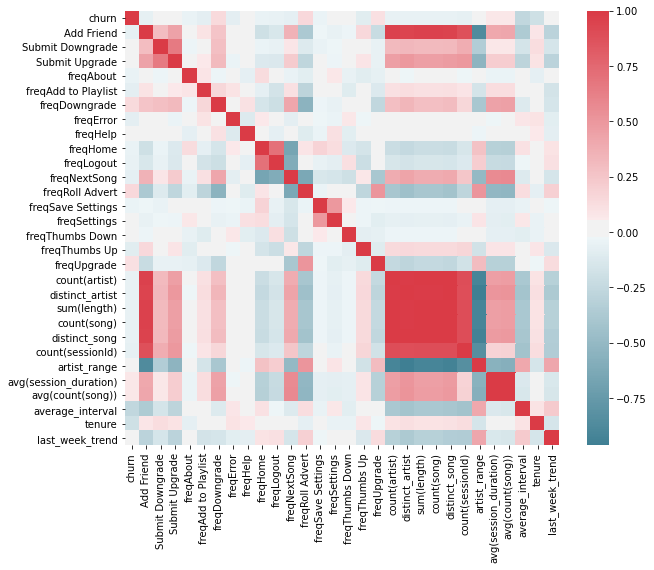

In [54]:
import seaborn as sns

f, ax = plt.subplots(figsize=(10, 8))
corr = df_page_pivot.toPandas().corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

### Find highly correlated features and drop them

In [55]:
# Calculate the correlation matrix and take the absolute value
corr_matrix = df_page_pivot.toPandas().corr().abs()

# Create a True/False mask and apply it
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
tri_df = corr_matrix.mask(mask)

# List column names of highly correlated features (r > 0.95)
to_drop = [c for c in tri_df.columns if any(tri_df[c] > 0.95)]

to_drop

['Add Friend',
 'count(artist)',
 'distinct_artist',
 'sum(length)',
 'count(song)',
 'avg(session_duration)']

In [56]:
c1 = df_page_pivot.toPandas().corr().abs().unstack()
c1.sort_values(ascending = False)[:32]

last_week_trend        last_week_trend          1.0
freqThumbs Down        freqThumbs Down          1.0
avg(count(song))       avg(count(song))         1.0
avg(session_duration)  avg(session_duration)    1.0
artist_range           artist_range             1.0
count(sessionId)       count(sessionId)         1.0
distinct_song          distinct_song            1.0
count(song)            count(song)              1.0
                       count(artist)            1.0
sum(length)            sum(length)              1.0
distinct_artist        distinct_artist          1.0
count(artist)          count(song)              1.0
                       count(artist)            1.0
freqUpgrade            freqUpgrade              1.0
freqThumbs Up          freqThumbs Up            1.0
freqSettings           freqSettings             1.0
tenure                 tenure                   1.0
freqSave Settings      freqSave Settings        1.0
freqRoll Advert        freqRoll Advert          1.0
freqNextSong

In [57]:
c1.sort_values(ascending = False)[32:].head(30)

count(artist)          sum(length)              0.999943
sum(length)            count(song)              0.999943
count(song)            sum(length)              0.999943
sum(length)            count(artist)            0.999943
distinct_song          count(artist)            0.997662
count(artist)          distinct_song            0.997662
distinct_song          count(song)              0.997662
count(song)            distinct_song            0.997662
sum(length)            distinct_song            0.997644
distinct_song          sum(length)              0.997644
avg(session_duration)  avg(count(song))         0.994315
avg(count(song))       avg(session_duration)    0.994315
distinct_song          distinct_artist          0.994280
distinct_artist        distinct_song            0.994280
                       sum(length)              0.985081
sum(length)            distinct_artist          0.985081
count(artist)          distinct_artist          0.985016
distinct_artist        count(ar

-  Count song and count artist almost counts same played rows and highly correlated, I will drop count artist.

-  Artist range and count(distinct artist) correlated , I will drop count(distinct artist), since we have artist range KPI.

-  Since artist range measures musical usage versatility, we can drop count(distinct song) feature. Because count song and count(distinct song) are highly correlated too.

-  Average song count per session and average session duration are highly correlated, I will drop average song count.

-  Count song and sum(length) are highly correlated, I will drop sum(lenghth).

-  Add friend and count song are correlated, I will drop add friend.

-  Features to drop = "count(artist)", "count(DISTINCT artist)", "avg(count(song))","sum(lenghth)","count(DISTINCT song)"

Code for finding high correlated features : https://campus.datacamp.com/courses/dimensionality-reduction-in-python/feature-selection-i-selecting-for-feature-information?ex=13

In [58]:
# Calculate the correlation matrix and take the absolute value
corr_matrix = df_page_pivot.toPandas().drop(['count(artist)',
 'distinct_artist',
 'sum(length)',
 'avg(count(song))',"distinct_song"],axis=1).corr().abs()

# Create a True/False mask and apply it
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
tri_df = corr_matrix.mask(mask)

# List column names of highly correlated features (r > 0.95)
to_drop = [c for c in tri_df.columns if any(tri_df[c] > 0.95)]

to_drop

['Add Friend']

We dont have any highly correlated pairs if we remove what we find.

We drop these features from main dataframe with code below:

In [59]:
df_page_pivot = df_page_pivot.select([c for c in df_page_pivot.columns if c not in {'count(artist)',
 'distinct_artist',
 'sum(length)', "Add Friend",
 'avg(count(song))',"distinct_song"}])

We should drop userId feature and convert gender column to new columns by StringIndexer

In [60]:
df_page_pivot = df_page_pivot.select([c for c in df_page_pivot.columns if c not in {"userId"}])

In [61]:
from pyspark.ml.feature import StringIndexer

In [ ]:
indexer = StringIndexer(inputCol="gender", outputCol="gender_label")
df_page_pivot = indexer.fit(df_page_pivot).transform(df_page_pivot)
df_page_pivot = df_page_pivot.select([c for c in df_page_pivot.columns if c not in {"gender"}])

indexer = StringIndexer(inputCol="last(level)", outputCol="level_label")
df_page_pivot = indexer.fit(df_page_pivot).transform(df_page_pivot)
df_page_pivot = df_page_pivot.select([c for c in df_page_pivot.columns if c not in {"last(level)"}])

df_page_pivot.toPandas().head()

,churn,Submit Downgrade,Submit Upgrade,freqAbout,freqAdd to Playlist,freqDowngrade,freqError,freqHelp,freqHome,freqLogout,...,freqUpgrade,count(song),count(sessionId),artist_range,avg(session_duration),average_interval,tenure,last_week_trend,gender_label,level_label
0,1,0,0,0.000000,0.007576,0.000000,0.0,0.000000,0.022727,0.007576,...,0.015152,96,2,0.979167,210.375000,1.521562,14.328449,0.995025,1.0,1.0
1,1,0,1,0.002564,0.015385,0.007692,0.0,0.002564,0.058974,0.028205,...,0.005128,310,5,0.925806,263.060000,5.749065,53.323148,0.990099,0.0,0.0
2,1,0,1,0.000000,0.020408,0.006803,0.0,0.013605,0.047619,0.020408,...,0.006803,112,5,0.964286,97.036667,1.642322,26.638264,0.598802,1.0,0.0
3,0,0,0,0.000000,0.024691,0.000000,0.0,0.024691,0.024691,0.000000,...,0.000000,62,3,0.983871,84.983333,14.570478,105.422118,0.990099,0.0,1.0
4,1,0,0,0.001410,0.021147,0.009868,0.0,0.004699,0.032895,0.007989,...,0.000000,1826,17,0.679080,445.667647,2.411460,112.553796,0.713267,1.0,0.0


# 4. Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

### Check Null Values

In [ ]:
from pyspark.sql.functions import isnan, when, count, col

df_page_pivot.select([count(when(isnan(c), c)).alias(c) for c in df_page_pivot.columns]).toPandas().unstack()

churn                  0    0
Submit Downgrade       0    0
Submit Upgrade         0    0
freqAbout              0    0
freqAdd to Playlist    0    0
freqDowngrade          0    0
freqError              0    0
freqHelp               0    0
freqHome               0    0
freqLogout             0    0
freqNextSong           0    0
freqRoll Advert        0    0
freqSave Settings      0    0
freqSettings           0    0
freqThumbs Down        0    0
freqThumbs Up          0    0
freqUpgrade            0    0
count(song)            0    0
count(sessionId)       0    0
artist_range           0    0
avg(session_duration)  0    0
average_interval       0    0
tenure                 0    0
last_week_trend        0    0
gender_label           0    0
level_label            0    0
dtype: int64

Fill NA values if any in future:

In [ ]:
#for categorical features
for col_name in ['gender_label', 'level_label']:
    common = df_page_pivot.dropna().groupBy(col_name).agg(F.count("*")).orderBy('count(1)', ascending=False).first()[col_name]
    df_page_pivot = df_page_pivot.withColumn(col_name, F.when(F.isnull(col_name), common).otherwise(df_page_pivot[col_name]))

In [ ]:
## Change dtype to double to imputing
for column in ['churn','Submit Downgrade', 'Submit Upgrade', 'freqAbout','freqAdd to Playlist', 'freqDowngrade',
 'freqError','freqHelp','freqHome','freqLogout','freqNextSong', 'freqRoll Advert', 'freqSave Settings', 'freqSettings',
 'freqThumbs Down','freqThumbs Up','freqUpgrade','count(song)','count(sessionId)', 'artist_range',
'avg(session_duration)','average_interval','tenure','last_week_trend']:
    df_page_pivot = df_page_pivot.withColumn(column, col(column).cast("double"))

In [ ]:
df_page_pivot.dtypes

[('churn', 'double'),
 ('Submit Downgrade', 'double'),
 ('Submit Upgrade', 'double'),
 ('freqAbout', 'double'),
 ('freqAdd to Playlist', 'double'),
 ('freqDowngrade', 'double'),
 ('freqError', 'double'),
 ('freqHelp', 'double'),
 ('freqHome', 'double'),
 ('freqLogout', 'double'),
 ('freqNextSong', 'double'),
 ('freqRoll Advert', 'double'),
 ('freqSave Settings', 'double'),
 ('freqSettings', 'double'),
 ('freqThumbs Down', 'double'),
 ('freqThumbs Up', 'double'),
 ('freqUpgrade', 'double'),
 ('count(song)', 'double'),
 ('count(sessionId)', 'double'),
 ('artist_range', 'double'),
 ('avg(session_duration)', 'double'),
 ('average_interval', 'double'),
 ('tenure', 'double'),
 ('last_week_trend', 'double'),
 ('gender_label', 'double'),
 ('level_label', 'double')]

Now we can impute numerical features too.

In [ ]:
from pyspark.ml.feature import Imputer

imputer = Imputer(
inputCols=['Submit Downgrade', 'Submit Upgrade', 'freqAbout','freqAdd to Playlist', 'freqDowngrade',
 'freqError','freqHelp','freqHome','freqLogout','freqNextSong', 'freqRoll Advert', 'freqSave Settings', 'freqSettings',
 'freqThumbs Down','freqThumbs Up','freqUpgrade','count(song)','count(sessionId)', 'artist_range',
'avg(session_duration)','average_interval','tenure','last_week_trend'],
outputCols=['Submit Downgrade', 'Submit Upgrade', 'freqAbout','freqAdd to Playlist', 'freqDowngrade',
 'freqError','freqHelp','freqHome','freqLogout','freqNextSong', 'freqRoll Advert', 'freqSave Settings', 'freqSettings',
 'freqThumbs Down','freqThumbs Up','freqUpgrade','count(song)','count(sessionId)', 'artist_range',
'avg(session_duration)','average_interval','tenure','last_week_trend'])
imputer.fit(df_page_pivot).transform(df_page_pivot)

DataFrame[churn: double, Submit Downgrade: double, Submit Upgrade: double, freqAbout: double, freqAdd to Playlist: double, freqDowngrade: double, freqError: double, freqHelp: double, freqHome: double, freqLogout: double, freqNextSong: double, freqRoll Advert: double, freqSave Settings: double, freqSettings: double, freqThumbs Down: double, freqThumbs Up: double, freqUpgrade: double, count(song): double, count(sessionId): double, artist_range: double, avg(session_duration): double, average_interval: double, tenure: double, last_week_trend: double, gender_label: double, level_label: double]

### Train Test Split

In [ ]:
train, test = df_page_pivot.randomSplit([0.8, 0.2], seed=42)

In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression,RandomForestClassifier, GBTClassifier, DecisionTreeClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.feature import MinMaxScaler, StringIndexer, VectorAssembler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [ ]:
feature_columns = [col for col in df_page_pivot.columns if col!='churn'] 

### Evaluation Metric 

In [ ]:
df_page_pivot.filter(df_page_pivot.churn == 1).count() / df_page_pivot.count()

0.22098214285714285

We have only 22% churn user, so we should measure F1 Score for our models.

If we measure by accuracy , we can predict all samples as class 0 and achieve 77% accuracy :)

F1 will be a good measure for measuring churn.

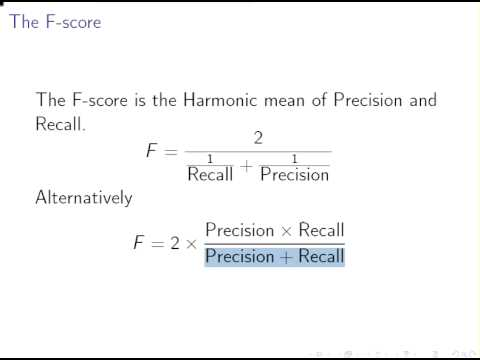

### Model Building and Evaulation Functions

Since we will try many algorithms we should implement a function to apply them properly.

In [ ]:
def create_CV_model(classifier,parameters,train):
    '''
    This function will create a cross validation object and return a trained model
    
    Input:
    classifier: a spark ml classification algorithm
    paramaters: parameter list to make grid search
    
    Output:
    fit_model: cross validation fitted model object
    '''
    
    assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
    scaler = MinMaxScaler(inputCol="features", outputCol="scaled_features")

    pipeline = Pipeline(stages=[assembler, scaler, classifier])

    model = CrossValidator(
        estimator=pipeline,
        estimatorParamMaps=parameters,
        evaluator = MulticlassClassificationEvaluator(labelCol="churn",metricName='f1'),
        numFolds=3)
    fit_model = model.fit(train)
    
    return fit_model

In [ ]:
def evaluate_model(model,train,test):
    '''
    This function will evaluate fitted model
    
    Input:
    model: fitted model after applying first function
    train: train data for evaluation 
    test: test data for real validation
    
    Output: a dataframe to show result metrics
    f1train: F1 Score for train data
    f1test: F1 Score for test data
    accuracy_train: Accuracy Score for train data
    accuracy_test: Accuracy Score for test data
    
    '''
    
    pred = model.transform(train)
    evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="churn")
    f1_train = evaluator.evaluate(pred, {evaluator.metricName: "f1"})
    accuracy_train = evaluator.evaluate(pred, {evaluator.metricName: "accuracy"})
    
    pred = model.transform(test)
    evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="churn")
    f1_test = evaluator.evaluate(pred, {evaluator.metricName: "f1"})
    accuracy_test = evaluator.evaluate(pred, {evaluator.metricName: "accuracy"})
    
    df = pd.Series({'F1 Train': f1_train, 
               'Accuracy Train': accuracy_train,
               'F1 Test': f1_test,
               'Accuracy Test' :accuracy_test })
    return df

### Logistic Regression

In [ ]:
# Train the model and evaluate performance on both train and test set
classifier = LogisticRegression(labelCol="churn", featuresCol="scaled_features")
paramGrid=ParamGridBuilder().build()

modelLR = create_CV_model(classifier,paramGrid, train)
df_log = evaluate_model(modelLR,train,test)
df_log

F1 Train          0.838961
Accuracy Train    0.853659
F1 Test           0.901327
Accuracy Test     0.911392
dtype: float64

### Decision Tree Classifier

In [171]:
# Train the model and evaluate performance on both train and test set
classifier = DecisionTreeClassifier(labelCol="churn", featuresCol="scaled_features")
paramGrid=ParamGridBuilder().build()

modelDT = create_CV_model(classifier,paramGrid, train)
df_dt = evaluate_model(modelDT,train,test)
df_dt

F1 Train          0.930277
Accuracy Train    0.932249
F1 Test           0.822785
Accuracy Test     0.822785
dtype: float64

### Random Forest 

In [172]:
# Train the model and evaluate performance
classifier = RandomForestClassifier(labelCol="churn", featuresCol="scaled_features")
paramGrid=ParamGridBuilder().build()

modelRF = create_CV_model(classifier,paramGrid, train)
df_rf = evaluate_model(modelRF,train,test)
df_rf

F1 Train          0.872015
Accuracy Train    0.886179
F1 Test           0.823369
Accuracy Test     0.860759
dtype: float64

### Gradient - Boosted Trees

In [173]:
# Train the model and evaluate performance
classifier = GBTClassifier(labelCol="churn", featuresCol="scaled_features")
paramGrid=ParamGridBuilder().build()

modelGB = create_CV_model(classifier,paramGrid, train)
df_gb = evaluate_model(modelGB,train,test)
df_gb

F1 Train          0.997285
Accuracy Train    0.997290
F1 Test           0.832475
Accuracy Test     0.835443
dtype: float64

In [174]:
frame = { 'LogisticRegression': df_log, 'DecisionTree': df_dt,
          'RandomForest': df_rf, 'GradientBoost': df_gb } 

results = pd.DataFrame(frame) 


results.transpose()

,F1 Train,Accuracy Train,F1 Test,Accuracy Test
LogisticRegression,0.835409,0.850949,0.890075,0.911392
DecisionTree,0.930277,0.932249,0.822785,0.822785
RandomForest,0.872015,0.886179,0.823369,0.860759
GradientBoost,0.997285,0.997290,0.832475,0.835443


From results above, we can state that best algorithm is random forest for our data. Gradient Boost seems to overfit on data.

### Hyperparameter Tuning for Logistic Regression

In [176]:
# Grid Search best parameters for logistic regression model and evaluate performance
classifier = LogisticRegression(labelCol="churn", featuresCol="scaled_features")
param_grid = ParamGridBuilder().addGrid(classifier.regParam, [0.01, 0.1, 1.0, 10.0]) \
                                .addGrid(classifier.elasticNetParam, [0.0, 0.5, 1.0]).build()
            
modelLR_best = create_CV_model(classifier,param_grid, train)
df_LR_best = evaluate_model(modelLR_best,train,test)
df_LR_best

F1 Train          0.813412
Accuracy Train    0.834688
F1 Test           0.884027
Accuracy Test     0.898734
dtype: float64

## Feature Importances

In [85]:
modelLR.bestModel.stages[2].coefficients

DenseVector([0.3812, -0.1127, -3.6518, 0.0187, 4.332, -1.0506, 0.8507, 7.1282, -13.6082, -4.8135, 8.3028, -6.3053, 2.459, 5.4943, -0.1295, 0.97, -3.2198, 3.2846, 2.9926, 8.4439, -11.1191, -1.6072, -0.3016, 0.0193, -1.0325])

In [83]:
#Checking features importance
rf_feature_importance_df = pd.DataFrame()
rf_feature_importance_df['feature'] = feature_columns
rf_feature_importance_df['importance'] = modelLR.bestModel.stages[2].coefficients.values.tolist()
rf_feature_importance_df = rf_feature_importance_df.sort_values(by='importance', ascending=False).reset_index(drop=True)
rf_feature_importance_df

,feature,importance
0,avg(session_duration),8.443949
1,freqRoll Advert,8.302788
2,freqHome,7.128163
3,freqThumbs Down,5.494349
4,freqDowngrade,4.332013
5,count(sessionId),3.284568
6,artist_range,2.992558
7,freqSettings,2.459040
8,freqUpgrade,0.970031
9,freqHelp,0.850669


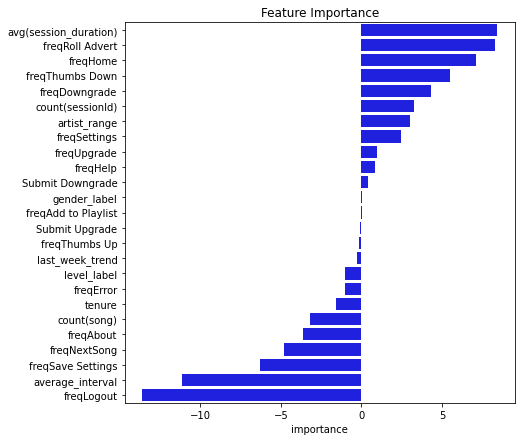

In [84]:
#Let's create a visualization of the feature importance for predicting churn
plt.figure(figsize=(7,7))
sns.barplot(x='importance', y='feature', data=rf_feature_importance_df, color="b")
plt.title('Feature Importance')
plt.ylabel('');

# 5. FINDINGS & CONCLUSION

In this project, we had a small-medium sized event type dataset for a fictional music app. 

We wanted to build a churn model who quit using the app. 

If we can forecast these customers before they leave, we can reach them and promote some campaigns or discounts and dont lose customer. 

This will make company more profitable. 

Analyzing dataset and features in it show some indicators about churn. In addition to these ready tabular formatted features, we added some features that measures user behavior, 
consumption and attributes. Adding these extra features have made our model more solid and powerful.

In the final section, we tried some ready models from pyspark.ml library and choiced Logistic Regression algorithm with default settings.
We could say our features in dataset effect our customers' churn probability increasingly or decreasingly. 
These weights of the features are model's parameters, the only difference is these total weights and multiplying with feature values gets 
into a sigmoid function and turn to a probability value for churning.

In this project , we used IBM Watson Studio and its' spark&hadoop features to analyze data more easily. We used pyspark python module to reach and work in spark&hadoop systems.

Many thanks to Udacity and data providers for this project. 

I hope you liked it and can give a good clap to my work :)